In [1]:
import os
thisDir = os.path.abspath(os.curdir)
os.chdir("../")

In [2]:
%matplotlib inline

In [6]:
import gpfanova, runFANOVA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
x,y,effect,labels= runFANOVA.loadData(heatshock=True,scaleX=False)
m = gpfanova.fanova.FANOVA(x,y,effect,interactions=True,helmertConvert=True,parameterFile='results/posteriorSamples_interactions_helmertConvert_heatshock.csv')

In [8]:
labels

Index([u'copR', u'VNG1029', u'idr2', u'hrg', u'sirR', u'troR', u'trmB',
       u'birA', u'VNG2268', u'trh4', u'VNG0039', u'cspD1', u'hlx1', u'kaiC',
       u'ura3', u'VNG0194H', u'idr1', u'asnC', u'trh2', u'hlx2', u'prp2',
       u'arcR', u'VNG2614', u'trh3', u'cspD2', u'VNG0471', u'phoU', u'rosR'],
      dtype='object')

In [9]:
ura3Ind = labels.tolist().index('ura3')
ura3Ind

14

In [10]:
labelsTrim = labels[labels!='ura3']
labelsTrim

Index([u'copR', u'VNG1029', u'idr2', u'hrg', u'sirR', u'troR', u'trmB',
       u'birA', u'VNG2268', u'trh4', u'VNG0039', u'cspD1', u'hlx1', u'kaiC',
       u'VNG0194H', u'idr1', u'asnC', u'trh2', u'hlx2', u'prp2', u'arcR',
       u'VNG2614', u'trh3', u'cspD2', u'VNG0471', u'phoU', u'rosR'],
      dtype='object')

In [22]:
import matplotlib as mpl
import scipy
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram

def extractDelta(deltas):
    p = len(deltas.keys())
    n = deltas[deltas.keys()[0]].shape[1]
    
    a = np.zeros((p,n))
    prob = np.zeros((p,n))
    
    keys = deltas.keys()
    
    for i,k in enumerate(keys):
        samples = deltas[k]
        med = np.median(samples,0)
        samples = np.sort(samples,0)
        ns = samples.shape[0]
        lb,ub = .025*ns,.975*ns
        lb,ub = samples[[lb,ub],:]

        a[i,:] = med
        prob[i,:] = ub*lb>0 # any bounds without matching signs crosses the origin
        
        
    return keys,a,prob
    

def plot_delta(x,deltas,probability=False,cluster=False,plot_cluster=False,cluster_kwargs={},dendrogram_kwargs={},ytick_filter=lambda x: x):
    p = len(deltas.keys())
    n = x.shape[0]
    a = np.zeros((p,n))
    prob = np.zeros((p,n))
    yticks = [ytick_filter(k) for k in deltas.keys()]
    
    clusterShape=4

    for i,k in enumerate(deltas.keys()):
        samples = deltas[k]
        med = np.median(samples,0)
        samples = np.sort(samples,0)
        ns = samples.shape[0]
        lb,ub = .025*ns,.975*ns
        lb,ub = samples[[lb,ub],:]

        a[i,:] = med
        prob[i,:] = ub*lb>0 # any bounds without matching signs crosses the origin

    if cluster:
        l = linkage(a,**cluster_kwargs)
        ind = leaves_list(l)
        a = a[ind,:]
        prob = prob[ind,:]
        yticks = [yticks[j] for j in ind]
        
        if plot_cluster:
            ax = plt.subplot2grid((1,clusterShape),(0,0),colspan=1,rowspan=1)
            dendrogram(l,no_labels=True,orientation='left',ax=ax,**dendrogram_kwargs)
            ax.set_xticks([])

    lim = np.max(np.abs(a))
    vmin = -lim
    vmax = lim

    if plot_cluster:
        ax = plt.subplot2grid((1,clusterShape),(0,1),colspan=clusterShape-1,rowspan=1)
    else:
        ax = plt.subplot2grid((1,5),(0,0),colspan=4,rowspan=1)
        
    if probability:
        # a[np.abs(prob-.5)<.475] = 0
        a[prob<1] = 0
        
    plt.imshow(a,cmap="RdBu_r",interpolation="none",vmin=vmin,vmax=vmax,origin='lower',aspect="auto")
    plt.yticks(range(p),yticks)
    i = np.arange(1.*n/4,n,1.*n/4)
    plt.xticks(i,[x[j].round(2) for j in i],fontsize=15)
    plt.xlabel("time (h)",fontsize=20)
    
    if plot_cluster:
#         if probability:
#             cbarAx,kwargs = mpl.colorbar.make_axes(ax)
#             cbar = mpl.colorbar.ColorbarBase(cbarAx,cmap='RdBu',ticks=[0,.5,1],**kwargs)
#             cbar.ax.set_yticklabels(['p(less\n than parent)\n>97.5%', 'no difference', 'p(greater\n than parent)\n>97.5%'],fontsize=15)
#         else:
        plt.colorbar()
    else:
        plt.colorbar()

In [15]:
# temporary workaround for mismatch in gpfanova versions
# newer version allows for multiple covariates, and assumes a lengthscale for each
# older version (where samples are from) does not

m.parameter_history['prior0_lengthscale0'] = m.parameter_history['prior0_lengthscale']
m.parameter_history['prior1_lengthscale0'] = m.parameter_history['prior1_lengthscale']
# m.parameter_history['prior2_lengthscale0'] = m.parameter_history['prior2_lengthscale']
# m.parameter_history['prior3_lengthscale0'] = m.parameter_history['prior3_lengthscale']

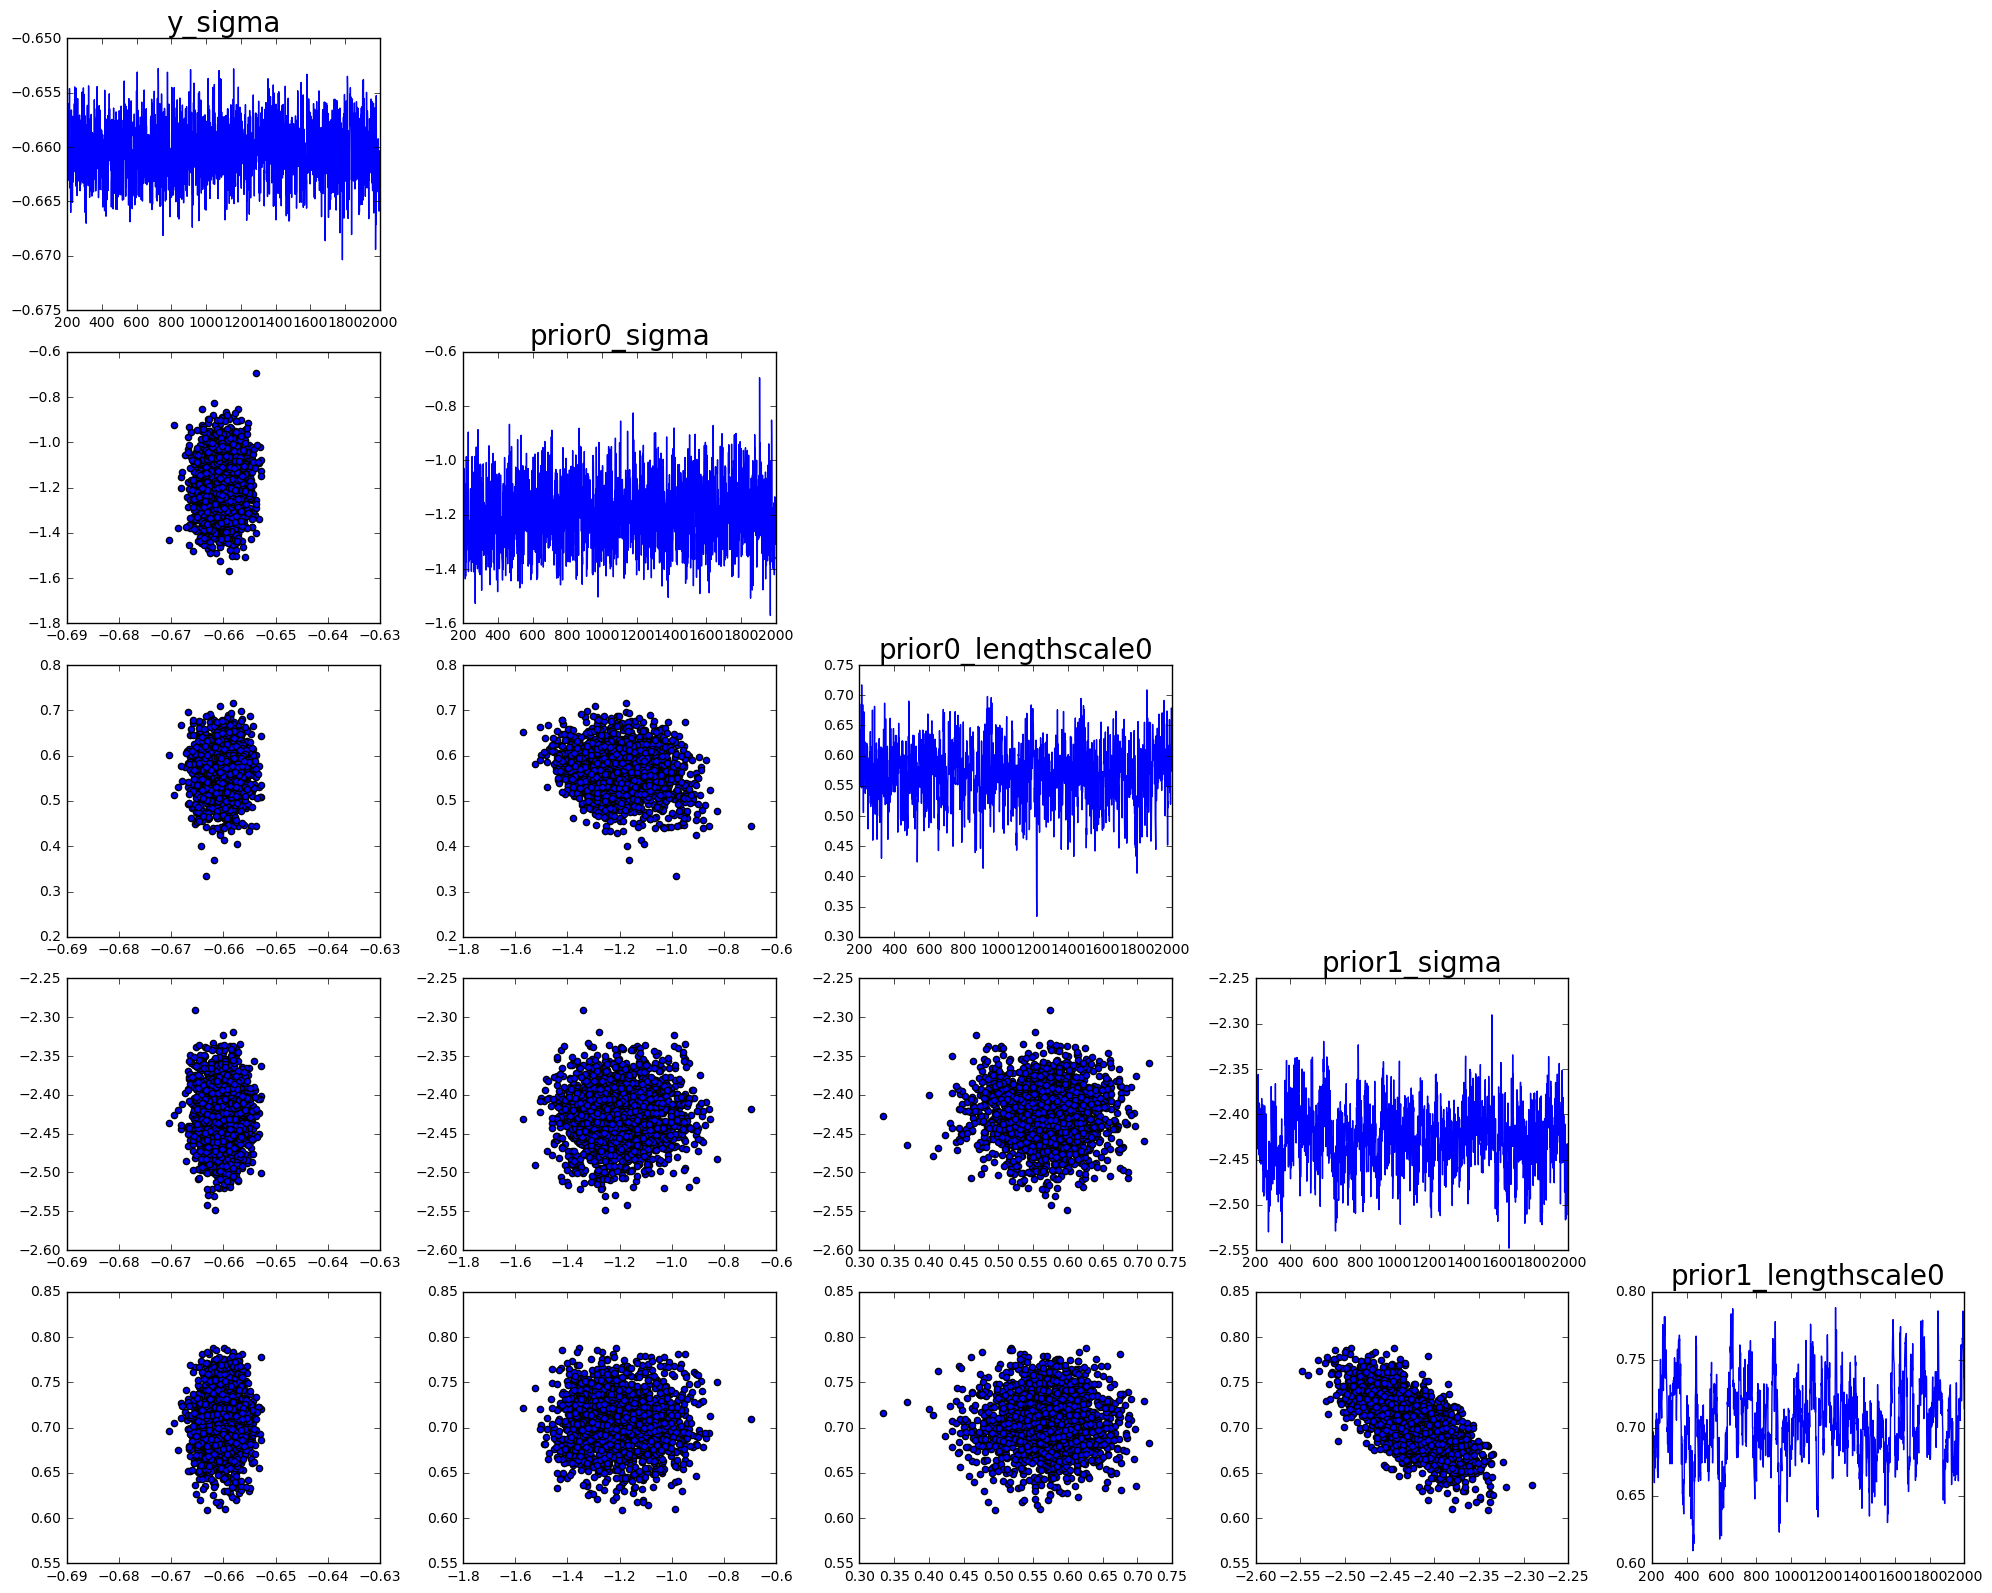

In [17]:
plt.figure(figsize=(20,16))
gpfanova.plot.plotHyperparameters(m,correlative=True,burnin=200)
plt.tight_layout(pad=1)
plt.savefig(os.path.join('figures','heatshock','hyperparameters.png'),bbox_inches='tight',dpi=300)

/home/ptonner/dev/hsalinarum_tf_phenotype/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


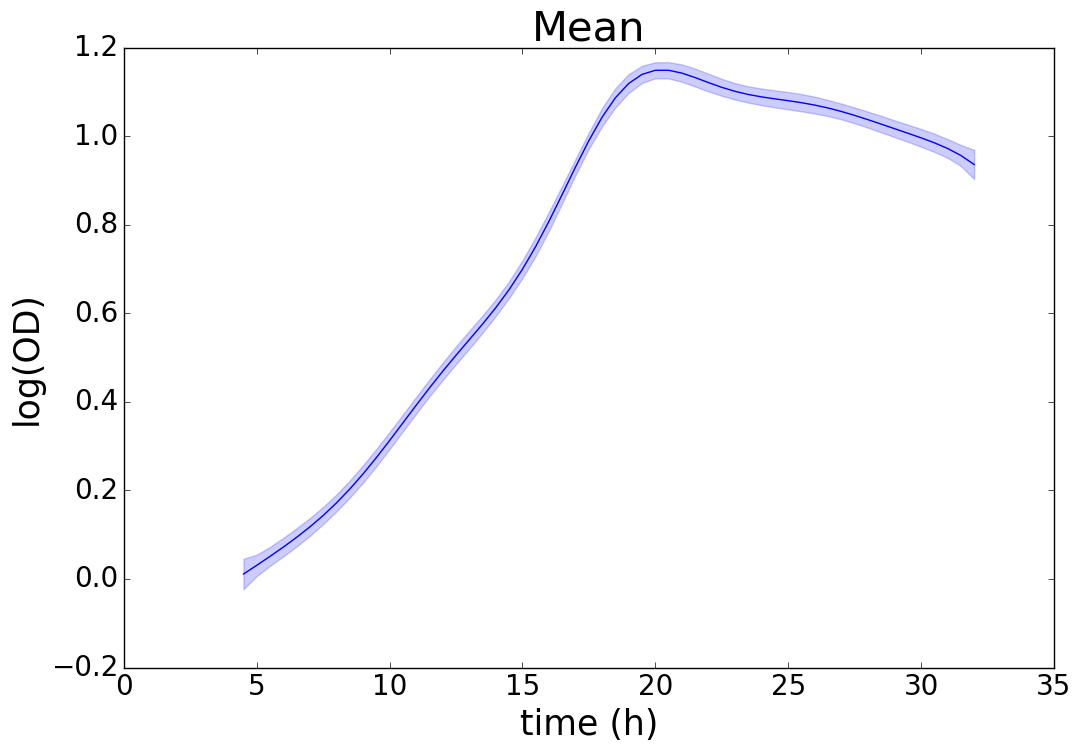

In [18]:
plt.figure(figsize=(12,8))
gpfanova.plot.plotFunctionSamples(m.parameterSamples('mean').values,x=m.x,intervalKwargs={'tol':1e-1})
plt.title("Mean",fontsize=30)
plt.legend(loc='best',fontsize=20)
plt.xlabel("time (h)",fontsize=25)
plt.ylabel("log(OD)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(os.path.join('figures','heatshock','mean.png'),bbox_inches='tight',dpi=300)

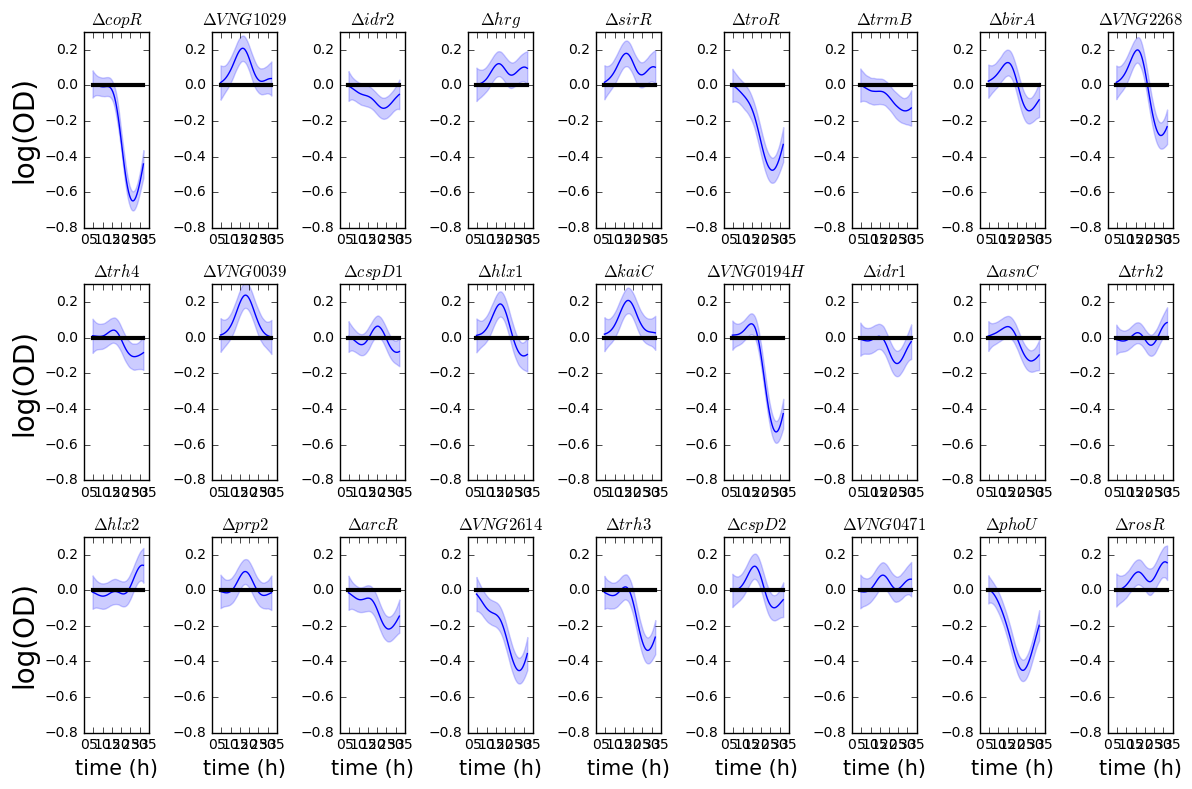

In [19]:
ura3 = m.parameterSamples('alpha_%d'%ura3Ind).values

plt.figure(figsize=(12,8))
for i,s in enumerate(labelsTrim):
    
    plt.subplot(3,9,i+1)
    samples = m.parameterSamples('alpha_%d'%(labels.tolist().index(s))).values
    gpfanova.plot.plotFunctionSamples(samples-ura3,m.x)
    plt.plot([m.x.min(),m.x.max()],[0,0],c='k',lw=3)
    plt.title(s)
    plt.ylim(-.8,.3)
    
for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labelsTrim[i]+"$");
#     plt.xticks([0,25,50])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)

plt.tight_layout()
plt.savefig(os.path.join('figures','heatshock','heatshock-full.pdf'),bbox_inches='tight',dpi=300)

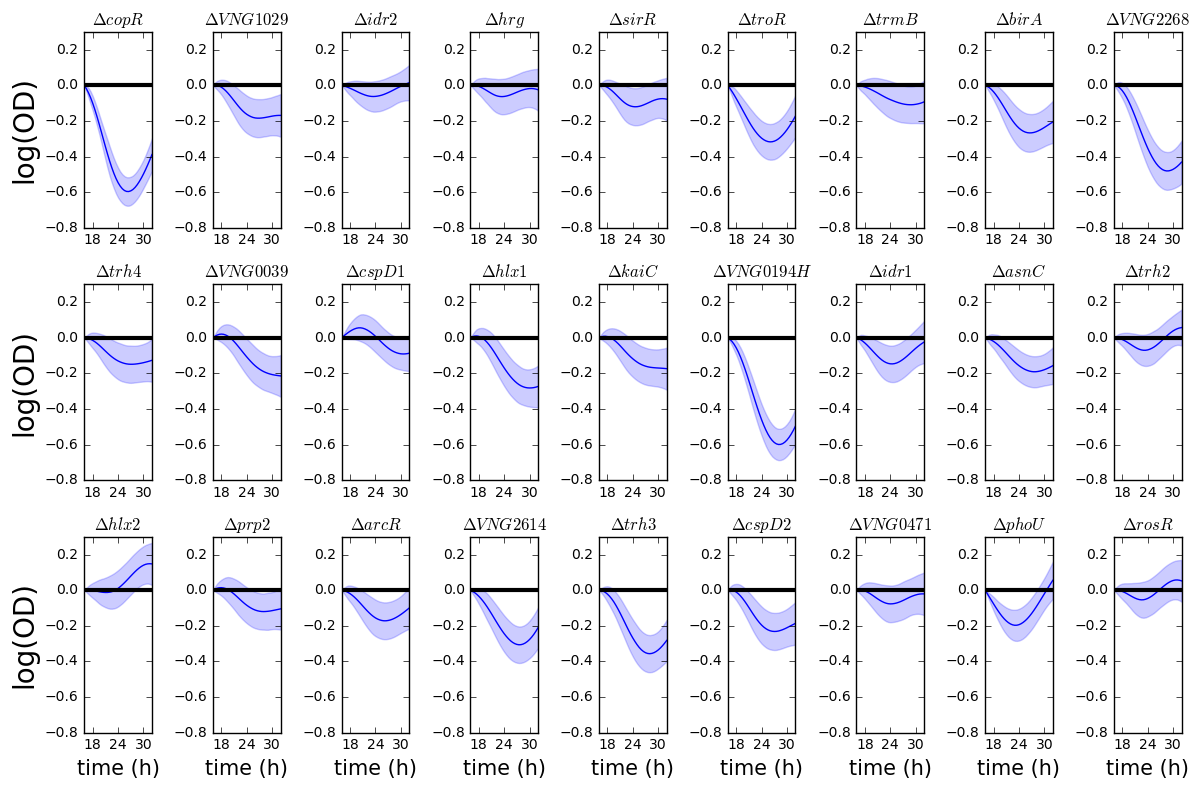

In [20]:
shiftInd = m.parameterSamples('mean').columns.tolist().index('f0([ 16.])')

ura3 = m.parameterSamples('alpha_%d'%ura3Ind).values[:,shiftInd:]

plt.figure(figsize=(12,8))
for i,s in enumerate(labelsTrim):
    
    plt.subplot(3,9,i+1)
    samples = m.parameterSamples('alpha_%d'%(labels.tolist().index(s))).values[:,shiftInd:]
    offset = samples[:,0].T - ura3[:,0].T
    offset = np.repeat(offset[:,None],samples.shape[1],1)
    gpfanova.plot.plotFunctionSamples(samples-ura3-offset,m.x[shiftInd:])
    plt.plot([m.x[shiftInd:].min(),m.x[shiftInd:].max()],[0,0],c='k',lw=3)
    plt.title(s)
    plt.ylim(-.8,.3)
    
for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labelsTrim[i]+"$");
    plt.xticks([18,24,30])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)

plt.tight_layout()
plt.savefig(os.path.join('figures','heatshock','heatshock-oddelta.pdf'),bbox_inches='tight',dpi=300)

/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


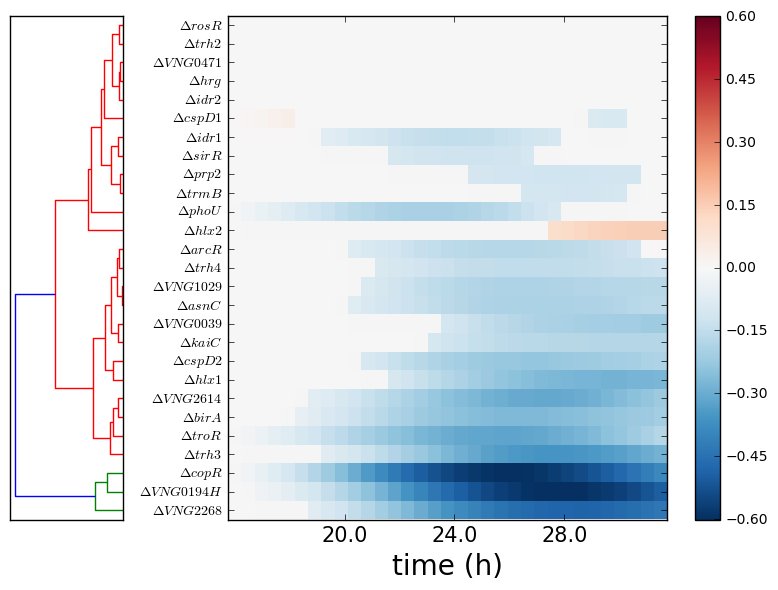

In [23]:
oddeltas = {}
shiftInd = m.parameterSamples('mean').columns.tolist().index('f0([ 16.])')
ura3 = m.parameterSamples('alpha_%d'%ura3Ind).values[:,shiftInd:]

for i,s in enumerate(labelsTrim):
    
    samples = m.parameterSamples('alpha_%d'%(labels.tolist().index(s))).values[:,shiftInd:]
    offset = samples[:,0].T - ura3[:,0].T
    offset = np.repeat(offset[:,None],samples.shape[1],1)
    oddeltas[s] = samples-ura3-offset
    
keys,med,prob = extractDelta(oddeltas)
pd.DataFrame(med,index=keys,columns=m.x[shiftInd:,0]).to_csv(os.path.join(thisDir,'heatshock_med.csv'))
pd.DataFrame(prob,index=keys,columns=m.x[shiftInd:,0]).to_csv(os.path.join(thisDir,'heatshock_prob.csv'))
    
plt.figure(figsize=(8,6))
# plot_delta(m.x[shiftInd:,0],oddeltas,cluster=True,probability=True,plot_cluster=True,ytick_filter=lambda x: '$\Delta '+x+'$')
plot_delta(m.x[shiftInd:,0],oddeltas,
            cluster=True,probability=True,plot_cluster=True,
            cluster_kwargs={"method":'complete'},dendrogram_kwargs={'color_threshold':2},
            ytick_filter=lambda x: '$\Delta '+x+'$')
plt.tight_layout()
plt.savefig(os.path.join('figures','heatshock-heatmap.pdf'),bbox_inches='tight',dpi=300)

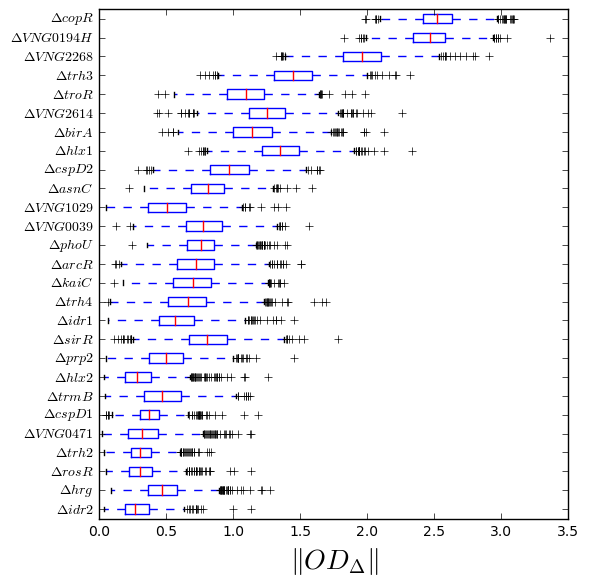

In [25]:
# ura3 = m.parameterSamples('alpha_0').values + m.parameterSamples('(alpha,beta)_(0,0)').values

oddeltaNorms = {}

for k in oddeltas.keys():
    oddeltaNorms[k] = np.power(np.power(oddeltas[k],2).sum(1),.5)

keys = oddeltas.keys()
oddeltaMeans = np.array([np.median(oddeltaNorms[k]) for k in keys])
index = np.argsort(oddeltaMeans)
oddeltasSorted = np.array([oddeltaNorms[k] for k in [oddeltaNorms.keys()[i] for i in index]])
labelsSort = ["$\Delta "+s+"$" for s in keys]
labelsSort = [labelsSort[i] for i in index]

plt.figure(figsize=(6,6))
plt.boxplot(oddeltasSorted.T,vert=False,labels=labelsSort);
plt.xlabel("$\|OD_\Delta\|$",fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join('figures','heatshock-oddeltaNorm.pdf'),bbox_inches='tight',dpi=300)

In [29]:
pd.DataFrame(oddeltaNorms).T.to_csv(os.path.join(thisDir,'heatshock_oddeltaNorm.csv'))